# Test mutation frequencies as targets

Test out mutation frequencies as an alternate target for the fitness model. First, load mutation frequencies calculated from a multiple sequence alignment (MSA) and the MSA itself. Prepare a table of mutations and their frequencies by strain.

Afterwards, load a table of strain (tip) attributes and use the tip timepoints, names, and frequencies to reweight the original mutation frequencies.

In [1]:
from augur.frequency_estimators import AlignmentKdeFrequencies
from Bio.Align import MultipleSeqAlignment
import Bio.AlignIO
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from treetime.utils import numeric_date

%matplotlib inline

In [2]:
start_timepoint = "2000-10-01"
timepoint = "2009-10-01"

In [3]:
genes = ["SigPep", "HA1", "HA2"]

In [4]:
data_root = "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/timepoints/%s/segments/ha/" % timepoint

In [5]:
with open(data_root + "mutation_frequencies.json", "r") as fh:
    mutation_frequencies = json.load(fh)

In [6]:
mutation_frequencies["HA1:144K"]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.00126,
 0.052814,
 0.000529,
 0.0,
 0.0,
 0.0,
 5e-06,
 0.104909,
 0.537553]

In [7]:
mutation_frequencies["HA1:144N"]

[0.670924,
 0.906275,
 0.706707,
 0.209355,
 0.216355,
 0.80787,
 0.925907,
 0.987684,
 0.984814,
 0.999976,
 0.99874,
 0.931158,
 0.925528,
 0.88477,
 0.949311,
 0.981837,
 0.983231,
 0.886609,
 0.462447]

In [8]:
mut_df = pd.DataFrame([
    {"site": mutation[:-1], "residue": mutation[-1], "frequency": frequencies[-1], "timepoint": timepoint}
    for mutation, frequencies in mutation_frequencies.items()
    if mutation != "pivots" and not mutation.endswith("counts")
])

In [9]:
mut_df.head(10)

,frequency,residue,site,timepoint
0,1.000000,P,HA1:103,2009-10-01
1,0.000000,Q,HA1:103,2009-10-01
2,0.000000,S,HA1:103,2009-10-01
3,1.000000,D,HA1:104,2009-10-01
4,0.000000,E,HA1:104,2009-10-01
5,0.006576,H,HA1:105,2009-10-01
6,0.993424,Y,HA1:105,2009-10-01
7,1.000000,A,HA1:106,2009-10-01
8,0.000000,S,HA1:106,2009-10-01
9,0.000000,T,HA1:106,2009-10-01


In [10]:
(mut_df["residue"] == "r").sum()

0

In [11]:
mut_df["residue"].value_counts()

I    82
S    76
K    69
N    68
V    67
R    59
T    57
L    50
D    43
G    40
A    39
E    34
F    29
Q    27
M    25
H    23
Y    23
P    22
C    10
W     5
*     1
Name: residue, dtype: int64

In [12]:
mut_df["site"].value_counts()

HA2:32       6
HA1:188      6
HA1:278      6
HA1:144      6
HA1:140      6
HA1:92       6
HA1:7        5
HA2:147      5
SigPep:12    5
SigPep:10    5
HA1:312      5
HA1:5        5
SigPep:9     5
HA1:121      5
SigPep:8     5
HA1:3        5
HA1:173      5
HA1:25       5
HA1:304      5
HA1:10       5
HA1:229      5
HA1:50       5
HA1:159      4
HA1:165      4
HA1:193      4
HA1:198      4
HA1:33       4
HA2:121      4
HA2:209      4
HA1:131      4
            ..
HA1:105      2
HA1:292      2
HA1:196      2
HA2:149      2
HA1:276      2
HA1:285      2
HA1:183      2
HA2:182      2
HA1:199      2
HA1:247      2
HA2:91       2
HA1:166      2
HA1:216      2
HA2:2        2
HA1:177      2
HA1:323      2
HA1:220      2
HA1:64       2
HA1:270      2
HA1:310      2
HA1:160      2
HA2:198      2
HA2:87       2
HA1:271      2
HA2:46       2
HA1:85       2
HA1:150      2
HA1:239      2
HA2:18       2
HA2:173      2
Name: site, Length: 303, dtype: int64

In [13]:
mut_df.head()

,frequency,residue,site,timepoint
0,1.0,P,HA1:103,2009-10-01
1,0.0,Q,HA1:103,2009-10-01
2,0.0,S,HA1:103,2009-10-01
3,1.0,D,HA1:104,2009-10-01
4,0.0,E,HA1:104,2009-10-01


In [14]:
max_frequency_by_site = mut_df.groupby("site")["frequency"].max().reset_index()

In [15]:
max_frequency_by_site[max_frequency_by_site["site"] == "HA2:181"]

,site,frequency
230,HA2:181,0.985771


In [16]:
sites_to_track = max_frequency_by_site.loc[max_frequency_by_site["frequency"] < 0.95, "site"].values

In [17]:
sites_to_track

array(['HA1:144', 'HA1:158', 'HA1:162', 'HA1:189', 'HA1:212', 'HA1:213',
       'HA1:260', 'HA1:261', 'HA1:62'], dtype=object)

In [18]:
sites_to_track.shape

(9,)

In [19]:
muts_to_track_df = mut_df[mut_df["site"].isin(sites_to_track)].copy()

In [20]:
muts_to_track_df

,frequency,residue,site,timepoint
71,0.000000,D,HA1:144,2009-10-01
72,0.000000,G,HA1:144,2009-10-01
73,0.000000,I,HA1:144,2009-10-01
74,0.537553,K,HA1:144,2009-10-01
75,0.462447,N,HA1:144,2009-10-01
76,0.000000,S,HA1:144,2009-10-01
95,0.176507,K,HA1:158,2009-10-01
96,0.787381,N,HA1:158,2009-10-01
97,0.036112,R,HA1:158,2009-10-01
108,0.918551,P,HA1:162,2009-10-01


In [21]:
sites_to_track

array(['HA1:144', 'HA1:158', 'HA1:162', 'HA1:189', 'HA1:212', 'HA1:213',
       'HA1:260', 'HA1:261', 'HA1:62'], dtype=object)

In [22]:
genes_to_tracks = sorted(set([site.split(":")[0] for site in sites_to_track]))

In [23]:
genes_to_tracks

['HA1']

In [24]:
positions_per_gene = defaultdict(list)

for site in sites_to_track:
    gene, position = site.split(":")
    positions_per_gene[gene].append(int(position))

In [25]:
positions_per_gene

defaultdict(list, {'HA1': [144, 158, 162, 189, 212, 213, 260, 261, 62]})

In [26]:
samples_and_sites = []

for gene in genes_to_tracks:
    with open(data_root + "aa-seq_%s.fasta" % gene, "r") as fh:
        alignment = Bio.AlignIO.read(fh, "fasta")
        
        for record in alignment:
            # Skip internal nodes.
            if record.id.startswith("NODE"):
                continue
                
            # Store this record's sequence for each site to track.
            for position in positions_per_gene[gene]:
                samples_and_sites.append({
                    "site": "%s:%s" % (gene, position),
                    "residue": record.seq[position - 1],
                    "sample": record.id
                })

samples_and_sites_df = pd.DataFrame(samples_and_sites)

In [27]:
samples_and_sites_df.shape

(12150, 3)

In [28]:
samples_and_sites_df.head(10)

,residue,sample,site
0,N,A/Canterbury/96/2000,HA1:144
1,K,A/Canterbury/96/2000,HA1:158
2,P,A/Canterbury/96/2000,HA1:162
3,S,A/Canterbury/96/2000,HA1:189
4,T,A/Canterbury/96/2000,HA1:212
5,V,A/Canterbury/96/2000,HA1:213
6,I,A/Canterbury/96/2000,HA1:260
7,R,A/Canterbury/96/2000,HA1:261
8,E,A/Canterbury/96/2000,HA1:62
9,N,A/Canterbury/99/2000,HA1:144


In [29]:
number_of_samples_by_site_and_residue_df = samples_and_sites_df.groupby(["site", "residue"]).count().reset_index().rename(
    columns={"sample": "number_of_samples"}
)

In [30]:
number_of_samples_by_site_and_residue_df

,site,residue,number_of_samples
0,HA1:144,D,133
1,HA1:144,G,1
2,HA1:144,I,2
3,HA1:144,K,96
4,HA1:144,N,1115
5,HA1:144,S,3
6,HA1:158,K,1158
7,HA1:158,N,137
8,HA1:158,R,55
9,HA1:162,P,1338


In [31]:
muts_to_track_df.head()

,frequency,residue,site,timepoint
71,0.000000,D,HA1:144,2009-10-01
72,0.000000,G,HA1:144,2009-10-01
73,0.000000,I,HA1:144,2009-10-01
74,0.537553,K,HA1:144,2009-10-01
75,0.462447,N,HA1:144,2009-10-01


In [32]:
#muts_to_track_df = muts_to_track_df.merge(number_of_samples_by_site_and_residue_df, on=["site", "residue"])

In [33]:
#muts_to_track_df["frequency_per_sample"] = muts_to_track_df["frequency"] / muts_to_track_df["number_of_samples"]

In [34]:
muts_to_track_df.head()

,frequency,residue,site,timepoint
71,0.000000,D,HA1:144,2009-10-01
72,0.000000,G,HA1:144,2009-10-01
73,0.000000,I,HA1:144,2009-10-01
74,0.537553,K,HA1:144,2009-10-01
75,0.462447,N,HA1:144,2009-10-01


In [35]:
mut_freqs_per_sample = muts_to_track_df.merge(samples_and_sites_df, on=["site", "residue"])

In [36]:
mut_freqs_per_sample.head()

,frequency,residue,site,timepoint,sample
0,0.0,D,HA1:144,2009-10-01,A/NewYork/197/2003
1,0.0,D,HA1:144,2009-10-01,A/NewYork/193/2003
2,0.0,D,HA1:144,2009-10-01,A/Queensland/12/2001
3,0.0,D,HA1:144,2009-10-01,A/Queensland/17/2001
4,0.0,D,HA1:144,2009-10-01,A/NewYork/401/2001


In [37]:
#mut_freqs_per_sample.groupby(["site", "residue"]).aggregate({"frequency": "first", "frequency_per_sample": "sum"})

In [38]:
#mut_freqs_per_sample = mut_freqs_per_sample.drop(columns=["frequency", "number_of_samples"]).rename(columns={"frequency_per_sample": "frequency"}).copy()

In [39]:
mut_freqs_per_sample["mutation"] = mut_freqs_per_sample["site"] + mut_freqs_per_sample["residue"]

In [40]:
mut_freqs_per_sample.head()

,frequency,residue,site,timepoint,sample,mutation
0,0.0,D,HA1:144,2009-10-01,A/NewYork/197/2003,HA1:144D
1,0.0,D,HA1:144,2009-10-01,A/NewYork/193/2003,HA1:144D
2,0.0,D,HA1:144,2009-10-01,A/Queensland/12/2001,HA1:144D
3,0.0,D,HA1:144,2009-10-01,A/Queensland/17/2001,HA1:144D
4,0.0,D,HA1:144,2009-10-01,A/NewYork/401/2001,HA1:144D


## Scale mutation frequencies by sample frequencies

Although we have estimated mutation frequencies per sample in the data frame above, we want to have a generic function that reweights the frequencies in these frames by any collection of per-sample weights (usually sample frequencies). For example, we will want to know what the initial frequency of each mutation is at a timepoint based on scaling of the frequencies of the samples with those mutations. Then we want to calculate the rescaled frequencies for the same mutations after projecting the sample frequencies into the future.

Below is an attempt to design this generic function.

In [41]:
# Load sample (tip) attributes for this timepoint which includes frequency per sample.
samples_df = pd.read_csv(data_root + "tip_attributes.tsv", sep="\t", usecols=["strain", "timepoint", "frequency", "date"],
                        parse_dates=["date"])

In [42]:
samples_df.head()

,strain,date,timepoint,frequency
0,A/Alaska/4/2008,2008-08-10,2009-10-01,0.000000
1,A/Albania/250/2009,2009-02-25,2009-10-01,0.000933
2,A/Anguilla/4711/2009,2009-06-09,2009-10-01,0.007110
3,A/Argentina/305/2007,2007-06-19,2009-10-01,0.000000
4,A/Argentina/3689/2007,2007-03-21,2009-10-01,0.000000


In [43]:
samples_df.shape

(1350, 4)

In [44]:
samples_df.groupby("timepoint")["frequency"].sum()

timepoint
2009-10-01    1.000008
Name: frequency, dtype: float64

In [45]:
mut_freqs_per_sample.head()

,frequency,residue,site,timepoint,sample,mutation
0,0.0,D,HA1:144,2009-10-01,A/NewYork/197/2003,HA1:144D
1,0.0,D,HA1:144,2009-10-01,A/NewYork/193/2003,HA1:144D
2,0.0,D,HA1:144,2009-10-01,A/Queensland/12/2001,HA1:144D
3,0.0,D,HA1:144,2009-10-01,A/Queensland/17/2001,HA1:144D
4,0.0,D,HA1:144,2009-10-01,A/NewYork/401/2001,HA1:144D


In [46]:
mut_freqs_per_sample.shape

(12150, 6)

In [47]:
mut_freqs_with_sample_freqs = mut_freqs_per_sample.merge(
    samples_df,
    how="inner",
    left_on=["timepoint", "sample"],
    right_on=["timepoint", "strain"],
    suffixes=["", "_strain"]
)

In [48]:
mut_freqs_with_sample_freqs.shape

(12150, 9)

In [49]:
mut_freqs_with_sample_freqs.head()

,frequency,residue,site,timepoint,sample,mutation,strain,date,frequency_strain
0,0.000000,D,HA1:144,2009-10-01,A/NewYork/197/2003,HA1:144D,A/NewYork/197/2003,2003-03-14,0.0
1,0.176507,K,HA1:158,2009-10-01,A/NewYork/197/2003,HA1:158K,A/NewYork/197/2003,2003-03-14,0.0
2,0.918551,P,HA1:162,2009-10-01,A/NewYork/197/2003,HA1:162P,A/NewYork/197/2003,2003-03-14,0.0
3,0.000000,S,HA1:189,2009-10-01,A/NewYork/197/2003,HA1:189S,A/NewYork/197/2003,2003-03-14,0.0
4,0.751721,T,HA1:212,2009-10-01,A/NewYork/197/2003,HA1:212T,A/NewYork/197/2003,2003-03-14,0.0


In [50]:
mut_freqs_with_sample_freqs["scaled_frequency"] = mut_freqs_with_sample_freqs["frequency"] * mut_freqs_with_sample_freqs["frequency_strain"]

In [51]:
mut_freqs_with_sample_freqs.groupby(["timepoint", "site"])["frequency"].sum()

timepoint   site   
2009-10-01  HA1:144     567.233493
            HA1:158     314.252463
            HA1:162    1229.722086
            HA1:189     297.536902
            HA1:212     992.678786
            HA1:213     999.244122
            HA1:260    1264.962330
            HA1:261    1129.584684
            HA1:62      622.883932
Name: frequency, dtype: float64

In [52]:
mut_freqs_with_sample_freqs.groupby(["timepoint", "site"])["frequency_strain"].sum()

timepoint   site   
2009-10-01  HA1:144    1.000008
            HA1:158    1.000008
            HA1:162    1.000008
            HA1:189    1.000008
            HA1:212    1.000008
            HA1:213    1.000008
            HA1:260    1.000008
            HA1:261    1.000008
            HA1:62     1.000008
Name: frequency_strain, dtype: float64

In [53]:
mut_freqs_with_sample_freqs.groupby(["timepoint", "site"])["scaled_frequency"].sum()

timepoint   site   
2009-10-01  HA1:144    0.502824
            HA1:158    0.652430
            HA1:162    0.848468
            HA1:189    0.661510
            HA1:212    0.626732
            HA1:213    0.631197
            HA1:260    0.898312
            HA1:261    0.763306
            HA1:62     0.498496
Name: scaled_frequency, dtype: float64

In [54]:
mut_freqs_with_sample_freqs.loc[:, ["site", "residue", "frequency"]].drop_duplicates().groupby("site")["frequency"].sum()

site
HA1:144    1.000000
HA1:158    1.000000
HA1:162    0.999999
HA1:189    1.000001
HA1:212    1.000000
HA1:213    1.000000
HA1:260    1.000000
HA1:261    1.000000
HA1:62     1.000000
Name: frequency, dtype: float64

In [55]:
print(mut_freqs_with_sample_freqs.loc[mut_freqs_with_sample_freqs["site"] == "HA1:144", ["site", "residue", "frequency"]].drop_duplicates().sort_values(
    "frequency"
))

          site residue  frequency
0      HA1:144       D   0.000000
1197   HA1:144       G   0.000000
1206   HA1:144       I   0.000000
12123  HA1:144       S   0.000000
2088   HA1:144       N   0.462447
1224   HA1:144       K   0.537553


In [56]:
scaled_mut_freqs = mut_freqs_with_sample_freqs.groupby(["timepoint", "site", "residue"])["frequency_strain"].sum().reset_index()

In [57]:
scaled_mut_freqs.head()

,timepoint,site,residue,frequency_strain
0,2009-10-01,HA1:144,D,0.000000
1,2009-10-01,HA1:144,G,0.000000
2,2009-10-01,HA1:144,I,0.000000
3,2009-10-01,HA1:144,K,0.537552
4,2009-10-01,HA1:144,N,0.462456


In [58]:
print(scaled_mut_freqs[scaled_mut_freqs["site"] == "HA1:144"].sort_values("frequency_strain"))

    timepoint     site residue  frequency_strain
0  2009-10-01  HA1:144       D          0.000000
1  2009-10-01  HA1:144       G          0.000000
2  2009-10-01  HA1:144       I          0.000000
5  2009-10-01  HA1:144       S          0.000000
4  2009-10-01  HA1:144       N          0.462456
3  2009-10-01  HA1:144       K          0.537552


## Try out KDE-based mutation frequencies

In [59]:
kde_frequencies = AlignmentKdeFrequencies(
    proportion_wide=0.0,
    pivot_frequency=6,
    start_date=2000.75,
    end_date=2009.75
)

In [60]:
kde_frequencies.get_density_for_observation??

Signature:
kde_frequencies.get_density_for_observation(
    mu,
    pivots,
    sigma_narrow=0.08333333333333333,
    sigma_wide=0.25,
    proportion_wide=0.2,
    **kwargs,
)
Source:   
    @classmethod
    def get_density_for_observation(cls, mu, pivots, sigma_narrow=1/12.0, sigma_wide=3/12.0, proportion_wide=0.2, **kwargs):
        """Build a normal distribution centered across the given floating point date,
        mu, with a standard deviation based on the given sigma value and return
        the probability mass at each pivot. These mass values per pivot will form the
        input for a kernel density estimate across multiple observations.
        """
        initial_density = norm.pdf(pivots[0], loc=mu, scale=sigma_narrow)
        density = np.array([initial_density] + list(np.diff(norm.cdf(pivots, loc=mu, scale=sigma_narrow))))
        return density
File:      ~/miniconda3/envs/nextstrain/lib/python3.6/site-packages/augur/frequency_estimators.py
Type:      method


In [61]:
with open(data_root + "aa-seq_%s.fasta" % gene, "r") as fh:
    alignment = Bio.AlignIO.read(fh, "fasta")

In [62]:
alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (2450 records of length 329, SingleLetterAlphabet()) at 1a22daf160>

In [63]:
sample_alignment = MultipleSeqAlignment([record for record in alignment if not record.id.startswith("NODE")])

In [64]:
sample_alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (1350 records of length 329, SingleLetterAlphabet()) at 1a22daf5f8>

In [65]:
samples_df["numeric_date"] = samples_df["date"].apply(numeric_date)

In [66]:
date_by_sample = dict(samples_df.loc[:, ["strain", "numeric_date"]].values)

In [67]:
dates = [date_by_sample[record.id] for record in sample_alignment]

In [68]:
len(dates)

1350

In [69]:
sample_alignment[0]

SeqRecord(seq=Seq('QKLPGNDNSTATLCLGHHAVPNGTLVKTITNDQIEVTNATELVQSSSTGGICDS...QTR', SingleLetterAlphabet()), id='A/Canterbury/96/2000', name='A/Canterbury/96/2000', description='A/Canterbury/96/2000', dbxrefs=[])

In [70]:
np.array(mutation_frequencies["pivots"])

array([2000.75, 2001.25, 2001.75, 2002.25, 2002.75, 2003.25, 2003.75,
       2004.25, 2004.75, 2005.25, 2005.75, 2006.25, 2006.75, 2007.25,
       2007.75, 2008.25, 2008.75, 2009.25, 2009.75])

In [71]:
len(sample_alignment)

1350

In [72]:
dates[:5]

[2000.8213552361397,
 2000.8240930869267,
 2001.101300479124,
 2000.914442162902,
 2001.101300479124]

In [73]:
frequencies = kde_frequencies.estimate(sample_alignment, dates)

In [74]:
kde_frequencies.pivots

array([2000.75, 2001.25, 2001.75, 2002.25, 2002.75, 2003.25, 2003.75,
       2004.25, 2004.75, 2005.25, 2005.75, 2006.25, 2006.75, 2007.25,
       2007.75, 2008.25, 2008.75, 2009.25, 2009.75])

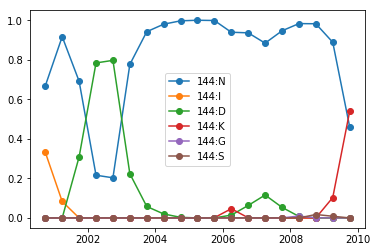

In [75]:
for key in frequencies.keys():
    if key.startswith("144:"):
        plt.plot(kde_frequencies.pivots, frequencies[key], "o-", label=key)

plt.legend()

In [76]:
kde_frequencies.pivots

array([2000.75, 2001.25, 2001.75, 2002.25, 2002.75, 2003.25, 2003.75,
       2004.25, 2004.75, 2005.25, 2005.75, 2006.25, 2006.75, 2007.25,
       2007.75, 2008.25, 2008.75, 2009.25, 2009.75])

In [77]:
np.array(mutation_frequencies["pivots"])

array([2000.75, 2001.25, 2001.75, 2002.25, 2002.75, 2003.25, 2003.75,
       2004.25, 2004.75, 2005.25, 2005.75, 2006.25, 2006.75, 2007.25,
       2007.75, 2008.25, 2008.75, 2009.25, 2009.75])

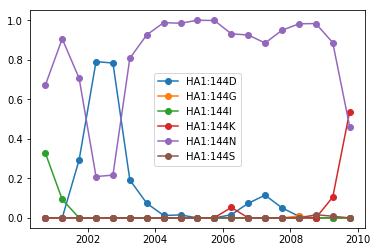

In [78]:
for key in mutation_frequencies.keys():
    if key.startswith("HA1:144"):
        plt.plot(mutation_frequencies["pivots"], mutation_frequencies[key], "o-", label=key)

plt.legend()

No handles with labels found to put in legend.


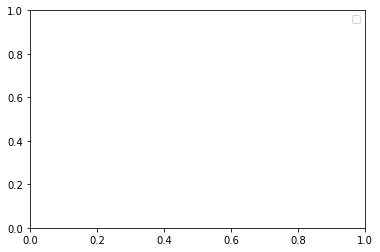

In [79]:
for key in frequencies.keys():
    if key.startswith("154:"):
        plt.plot(kde_frequencies.pivots, frequencies[key], "o-", label=key)

plt.legend()

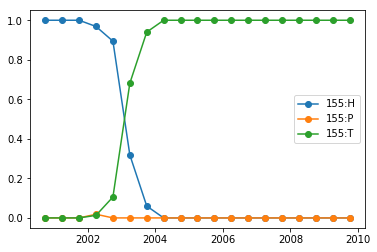

In [80]:
for key in frequencies.keys():
    if key.startswith("155:"):
        plt.plot(kde_frequencies.pivots, frequencies[key], "o-", label=key)

plt.legend()

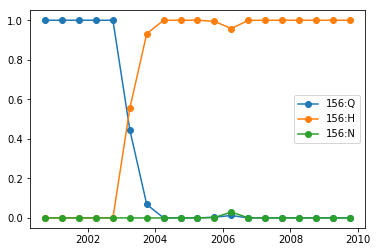

In [81]:
for key in frequencies.keys():
    if key.startswith("156:"):
        plt.plot(kde_frequencies.pivots, frequencies[key], "o-", label=key)

plt.legend()

## Inspect scaled mutation frequencies from all timepoints

In [82]:
df = pd.read_csv(
    "../results/builds/h3n2/20_viruses_per_month/sample_0/2000-10-01--2015-10-01/mutation_frequencies_by_tip.tsv",
    sep="\t",
    parse_dates=["timepoint"]
)

In [83]:
df.head()

,residue,site,strain,mutation,timepoint,frequency
0,P,HA1:103,A/HongKong/HKU2/2004,HA1:103P,2004-10-01,0.001207
1,Y,HA1:105,A/HongKong/HKU2/2004,HA1:105Y,2004-10-01,0.001207
2,N,HA1:121,A/HongKong/HKU2/2004,HA1:121N,2004-10-01,0.001207
3,S,HA1:124,A/HongKong/HKU2/2004,HA1:124S,2004-10-01,0.001207
4,D,HA1:126,A/HongKong/HKU2/2004,HA1:126D,2004-10-01,0.001207


In [84]:
df.shape

(899296, 6)

In [85]:
df_by_timepoint_and_mutation = df.groupby(["timepoint", "site", "residue", "mutation"])["frequency"].sum().reset_index()

In [86]:
df_by_timepoint_and_mutation.head()

,timepoint,site,residue,mutation,frequency
0,2004-10-01,HA1:103,P,HA1:103P,0.980490
1,2004-10-01,HA1:103,Q,HA1:103Q,0.019513
2,2004-10-01,HA1:105,H,HA1:105H,0.014087
3,2004-10-01,HA1:105,Y,HA1:105Y,0.985916
4,2004-10-01,HA1:121,N,HA1:121N,0.979939


In [87]:
timepoints_per_site = df_by_timepoint_and_mutation.loc[:, ["timepoint", "site"]].drop_duplicates().groupby("site")["timepoint"].count().reset_index()

In [88]:
timepoints_per_site.head()

,site,timepoint
0,HA1:1,6
1,HA1:10,16
2,HA1:100,3
3,HA1:101,3
4,HA1:102,1


In [89]:
timepoints_per_site["site"].shape

(427,)

In [90]:
(timepoints_per_site["timepoint"] == 1).sum()

33

In [91]:
(timepoints_per_site["timepoint"] > 1).sum()

394

In [92]:
(timepoints_per_site["timepoint"] > 18).sum()

29

In [93]:
sites_with_multiple_timepoints = timepoints_per_site[timepoints_per_site["timepoint"] > 18]["site"].values

In [94]:
min_max_frequency_per_site = df_by_timepoint_and_mutation.groupby(["site", "timepoint"])["frequency"].max().reset_index().groupby(
    "site"
)["frequency"].min().reset_index()

In [95]:
min_max_frequency_per_site.head()

,site,frequency
0,HA1:1,0.986223
1,HA1:10,0.970225
2,HA1:100,0.978072
3,HA1:101,0.994725
4,HA1:102,0.990389


In [96]:
sites_with_min_max_frequency = min_max_frequency_per_site[min_max_frequency_per_site["frequency"] < 0.8]["site"].values

In [97]:
sites_to_plot = set(sites_with_multiple_timepoints).intersection(set(sites_with_min_max_frequency))

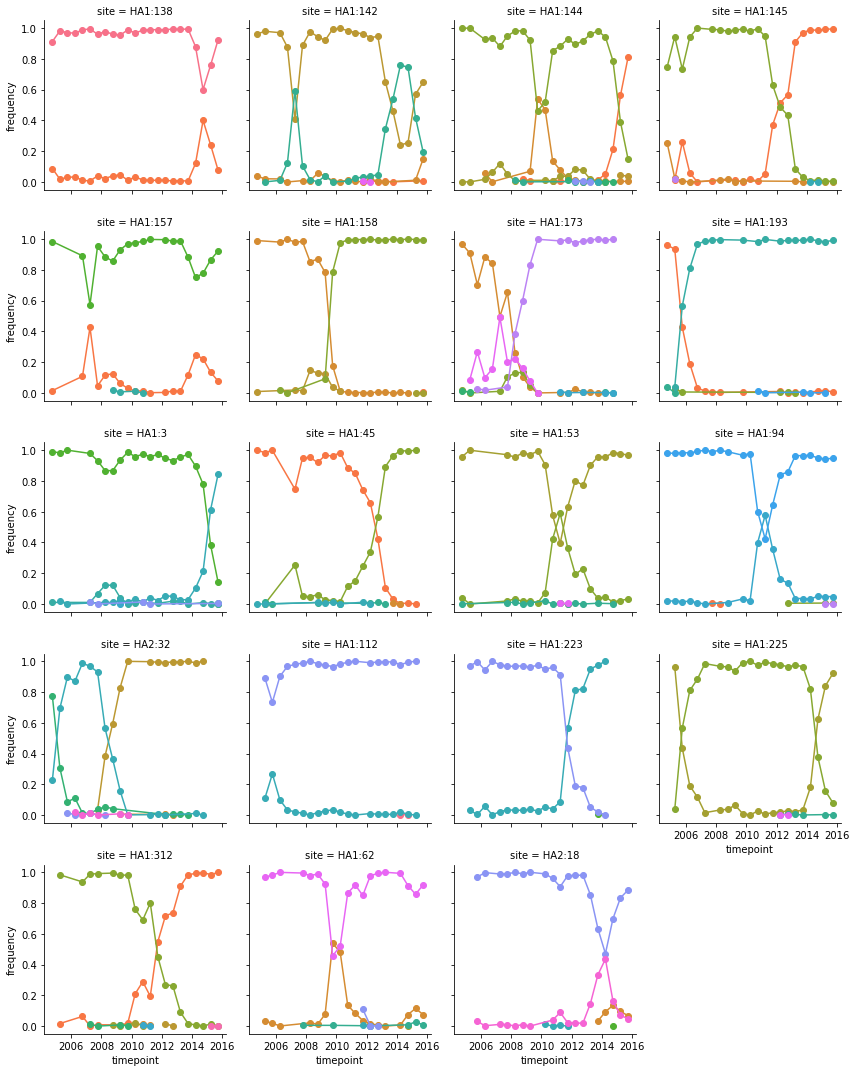

In [98]:
g = sns.FacetGrid(df_by_timepoint_and_mutation[df_by_timepoint_and_mutation["site"].isin(sites_to_plot)],
                  hue="residue", col="site", col_wrap=4)
g.map(plt.plot, "timepoint", "frequency", marker="o")

In [99]:
new_df = df_by_timepoint_and_mutation[df_by_timepoint_and_mutation["site"] == "HA1:144"]

In [100]:
new_df.head()

,timepoint,site,residue,mutation,frequency
17,2004-10-01,HA1:144,D,HA1:144D,0.000988
18,2004-10-01,HA1:144,N,HA1:144N,0.999015
184,2005-04-01,HA1:144,D,HA1:144D,0.000025
185,2005-04-01,HA1:144,N,HA1:144N,0.999973
482,2006-04-01,HA1:144,D,HA1:144D,0.017192


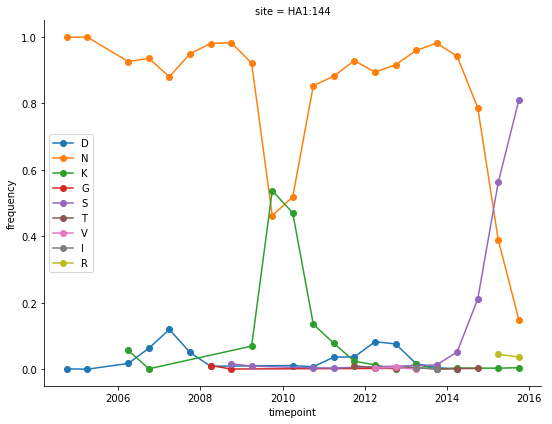

In [102]:
g = sns.FacetGrid(df_by_timepoint_and_mutation[df_by_timepoint_and_mutation["site"] == "HA1:144"],
                  hue="residue", col="site", col_wrap=4, height=6, aspect=1.21)
g.map(plt.plot, "timepoint", "frequency", marker="o")

g.axes[0].legend()

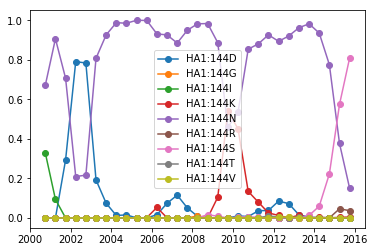

In [107]:
with open(data_root.replace("2009-10-01", "2015-10-01") + "mutation_frequencies.json", "r") as fh:
    mutation_frequencies = json.load(fh)

for key in mutation_frequencies.keys():
    if key.startswith("HA1:144"):
        plt.plot(mutation_frequencies["pivots"], mutation_frequencies[key], "o-", label=key)

plt.legend()

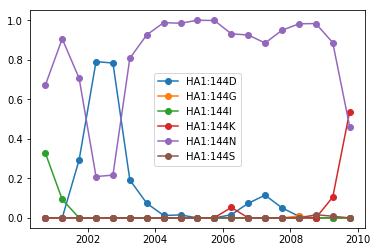

In [108]:
with open(data_root + "mutation_frequencies.json", "r") as fh:
    mutation_frequencies = json.load(fh)

for key in mutation_frequencies.keys():
    if key.startswith("HA1:144"):
        plt.plot(mutation_frequencies["pivots"], mutation_frequencies[key], "o-", label=key)

plt.legend()

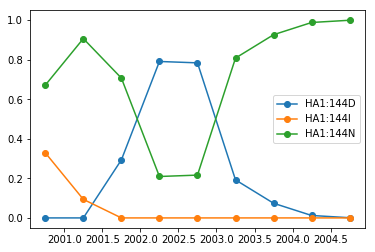

In [109]:
with open(data_root.replace("2009-10-01", "2004-10-01") + "mutation_frequencies.json", "r") as fh:
    mutation_frequencies = json.load(fh)

for key in mutation_frequencies.keys():
    if key.startswith("HA1:144"):
        plt.plot(mutation_frequencies["pivots"], mutation_frequencies[key], "o-", label=key)

plt.legend()